# Radar-IMU Velocity Synchronization v2

## Updated Approach

**Time Reference**: `/angrybird2/imu` acceleration integrated to velocity (for finding peaks)

**Velocity Reference**: `/angrybird2/agiros_pilot/state` linear velocity (for magnitude validation)

**Radar Estimation**: Weighted Least Squares (intensity-weighted) from `/mmWaveDataHdl/RScanVelocity`

This version:
1. Uses IMU integration to find temporal peaks (time alignment)
2. Uses Agiros state velocity to validate radar magnitude (is 1 m/s actually 1 m/s?)
3. Applies weighted least squares with intensity-based weights
4. Filters data to exclude initial transient period

In [1]:
import sys
sys.path.append("/workspace/analysis")

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, correlate
from scipy import stats
import rosbag_loader

%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 10)

## Configuration

In [2]:
# Select bag file with high speed motion
BAG_PATH = "/workspace/rosbags/2025-12-17-16-02-22.bag"

# Data filtering
START_TIME_OFFSET = 31.5  # Skip first N seconds (avoid transients)
DURATION = 15.0          # Analyze this many seconds of data

# Filtering thresholds for radar point cloud
MIN_INTENSITY = 5.0   # Minimum intensity to consider (filter noise)
MIN_RANGE = 0.2       # Minimum range in meters (filter clutter)
MIN_POINTS = 5        # Minimum points needed for least squares

# Signal processing
IMU_HIGHPASS_CUTOFF = 0.5   # Hz - removes integration drift
RADAR_LOWPASS_CUTOFF = 5.0  # Hz - smooths radar estimates

## Load Data

In [3]:
print(f"Loading {BAG_PATH}...\n")
data = rosbag_loader.load_bag_topics(BAG_PATH, verbose=True)

# Filter data to start after START_TIME_OFFSET
t_start = data.start_time + START_TIME_OFFSET
t_end = t_start + DURATION

print(f"\n=== Time Filtering ===")
print(f"Bag start time: {data.start_time:.2f} s")
print(f"Analysis start time: {t_start:.2f} s (offset: {START_TIME_OFFSET:.1f} s)")
print(f"Bag end time: {data.start_time + data.duration:.2f} s")

# Filter IMU data
data.imu_data = [imu for imu in data.imu_data if imu.timestamp >= t_start and imu.timestamp <= t_end]

# Filter Agiros state
data.agiros_state = [state for state in data.agiros_state if state.timestamp >= t_start and state.timestamp <= t_end]

# Filter Radar data
data.radar_velocity = [radar for radar in data.radar_velocity if radar.timestamp >= t_start and radar.timestamp <= t_end]

print(f"\n=== Data Summary (After Filtering) ===")
print(f"IMU samples: {len(data.imu_data)}")
print(f"Agiros state samples: {len(data.agiros_state)}")
print(f"Radar velocity frames: {len(data.radar_velocity)}")
if len(data.imu_data) > 0:
    filtered_duration = data.imu_data[-1].timestamp - data.imu_data[0].timestamp
    print(f"Filtered duration: {filtered_duration:.2f} s")

Loading /workspace/rosbags/2025-12-17-16-02-22.bag...


Loading rosbag: 2025-12-17-16-02-22.bag
Duration: 48.59s
  Loading /mocap/angrybird2/pose...
  Loading /mocap/angrybird2/accel...
  Loading /angrybird2/agiros_pilot/state...
  Loading /angrybird2/agiros_pilot/odometry...
  Loading /angrybird2/imu...
  Loading /ti_mmwave/radar_scan_pcl_0...
  Loading /mmWaveDataHdl/RScanVelocity...
  Done!


=== Time Filtering ===
Bag start time: 1765983743.29 s
Analysis start time: 1765983774.79 s (offset: 31.5 s)
Bag end time: 1765983791.88 s

=== Data Summary (After Filtering) ===
IMU samples: 14917
Agiros state samples: 4503
Radar velocity frames: 449
Filtered duration: 15.00 s


## Ego-Velocity Estimation via Weighted Least Squares

For each radar frame with $N$ points:

$$\mathbf{v}_{body} = \arg\min_{\vec{v}} \sum_{i=1}^{N} w_i (\hat{r}_i \cdot \vec{v} - v_{rad,i})^2$$

Where $w_i = \text{intensity}_i$ (trust brighter returns more)

**Weighted Least Squares**: $\vec{v}_{body} = (\mathbf{H}^T\mathbf{W}\mathbf{H})^{-1}\mathbf{H}^T\mathbf{W}\vec{z}$

In [4]:
def solve_ego_velocity_weighted(positions, velocities, intensities):
    """
    Solve for 3D body velocity using Weighted Least Squares.
    Higher intensity points are trusted more.
    
    Returns:
        v_body: 3D velocity vector [vx, vy, vz] or None
    """
    H = []
    z = []
    weights = []
    
    for i in range(len(positions)):
        x, y, z_coord = positions[i]
        v_rad = velocities[i]
        intensity = intensities[i]
        
        r = np.sqrt(x**2 + y**2 + z_coord**2)
        
        # Filter weak/close returns
        if intensity < MIN_INTENSITY or r < MIN_RANGE:
            continue
        
        # Unit direction vector
        dir_vec = np.array([x/r, y/r, z_coord/r])
        
        H.append(dir_vec)
        z.append(v_rad)
        weights.append(intensity)  # Weight by intensity
    
    if len(z) < MIN_POINTS:
        return None
    
    H = np.array(H)
    z = np.array(z)
    W = np.diag(weights)  # Weight matrix
    
    try:
        # Weighted Least Squares: (H^T W H)^-1 H^T W z
        lhs = H.T @ W @ H
        rhs = H.T @ W @ z
        v_body = np.linalg.solve(lhs, rhs)
        
        return v_body #!!!/np.cos(np.deg2rad(30))  # Adjust for radar mounting angle
        
    except np.linalg.LinAlgError:
        return None


# Process all radar frames
print("Estimating ego-velocity from radar (weighted least squares)...")

radar_times = []
radar_vx = []
radar_vy = []
radar_vz = []
radar_cpu_cycles = []

for frame in data.radar_velocity:
    if frame.velocities is None or frame.intensities is None:
        continue
    
    v_body = solve_ego_velocity_weighted(
        frame.positions,
        frame.velocities,
        frame.intensities
    )
    
    if v_body is not None:
        radar_times.append(frame.timestamp)
        radar_vx.append(v_body[0])
        radar_vy.append(v_body[1])
        radar_vz.append(v_body[2])
        
        if frame.time_cpu_cycles is not None and len(frame.time_cpu_cycles) > 0:
            radar_cpu_cycles.append(frame.time_cpu_cycles[0])
        else:
            radar_cpu_cycles.append(0)

radar_times = np.array(radar_times)
radar_vx = np.array(radar_vx)
radar_vy = np.array(radar_vy)
radar_vz = np.array(radar_vz)

print(f"Processed {len(radar_times)} radar frames")
print(f"Vx range: [{np.min(radar_vx):.2f}, {np.max(radar_vx):.2f}] m/s")

Estimating ego-velocity from radar (weighted least squares)...
Processed 292 radar frames
Vx range: [-1.64, 1.92] m/s


## Extract Ground Truth Signals

### IMU: Time Reference (Integration for peaks)
### Agiros State: Velocity Reference (Magnitude validation)

In [5]:
# Extract IMU acceleration (X-axis)
imu_times = np.array([imu.timestamp for imu in data.imu_data])
imu_ax = np.array([imu.linear_acceleration[0] for imu in data.imu_data])

print(f"IMU: {len(imu_times)} samples at {len(imu_times)/(imu_times[-1]-imu_times[0]):.1f} Hz")

# Extract Agiros State velocity (body frame linear velocity)
state_times = np.array([s.timestamp for s in data.agiros_state])
state_vx = np.array([s.velocity[0] for s in data.agiros_state])
state_vy = np.array([s.velocity[1] for s in data.agiros_state])
state_vz = np.array([s.velocity[2] for s in data.agiros_state])

print(f"State: {len(state_times)} samples at {len(state_times)/(state_times[-1]-state_times[0]):.1f} Hz")
print(f"State Vx range: [{np.min(state_vx):.2f}, {np.max(state_vx):.2f}] m/s")

IMU: 14917 samples at 994.6 Hz
State: 4503 samples at 300.2 Hz
State Vx range: [-0.88, 0.78] m/s


## IMU Integration (Time Reference)

In [6]:
# Remove bias
ax_bias = np.mean(imu_ax)
imu_ax_unbiased = imu_ax - ax_bias

print(f"IMU X-axis acceleration bias: {ax_bias:.3f} m/s²")

# Integrate
dt_imu = np.diff(imu_times)
dt_imu = np.insert(dt_imu, 0, dt_imu[0])
imu_vx_raw = np.cumsum(imu_ax_unbiased * dt_imu)

# High-pass filter to remove drift
fs_imu = 1.0 / np.mean(dt_imu)
b_hp, a_hp = butter(2, IMU_HIGHPASS_CUTOFF, btype='high', fs=fs_imu)
imu_vx_filt = filtfilt(b_hp, a_hp, imu_vx_raw)

print(f"IMU integrated velocity range: [{np.min(imu_vx_filt):.2f}, {np.max(imu_vx_filt):.2f}] m/s")

IMU X-axis acceleration bias: 1.089 m/s²
IMU integrated velocity range: [-0.78, 0.71] m/s


## Filter Radar Velocity

In [7]:
# Low-pass filter radar to smooth noise
fs_radar = len(radar_times) / (radar_times[-1] - radar_times[0])
b_lp, a_lp = butter(2, RADAR_LOWPASS_CUTOFF, btype='low', fs=fs_radar)
radar_vx_filt = filtfilt(b_lp, a_lp, radar_vx)

print(f"Radar sample rate: {fs_radar:.1f} Hz")
print(f"Filtered radar Vx range: [{np.min(radar_vx_filt):.2f}, {np.max(radar_vx_filt):.2f}] m/s")

Radar sample rate: 19.6 Hz
Filtered radar Vx range: [-1.58, 1.32] m/s


## Cross-Correlation for Time Alignment


=== TIME ALIGNMENT ===
Calculated lag: -15.08 ms
Interpretation: IMU peaks occur -15.08 ms AFTER Radar peaks

Top 10 closest extrema (min & max) to the main peak:
  max: lag=-15.08 ms, corr=4315.8092
  min: lag=-800.40 ms, corr=-4078.2032
  min: lag=790.34 ms, corr=-3962.6699
  max: lag=-1609.84 ms, corr=3753.5047
  max: lag=1593.75 ms, corr=3849.3295
  min: lag=-2406.21 ms, corr=-3525.1300
  min: lag=2400.18 ms, corr=-3599.8253
  max: lag=-3211.64 ms, corr=3371.9818
  max: lag=3193.54 ms, corr=3425.9048
  min: lag=-4004.99 ms, corr=-3112.0734


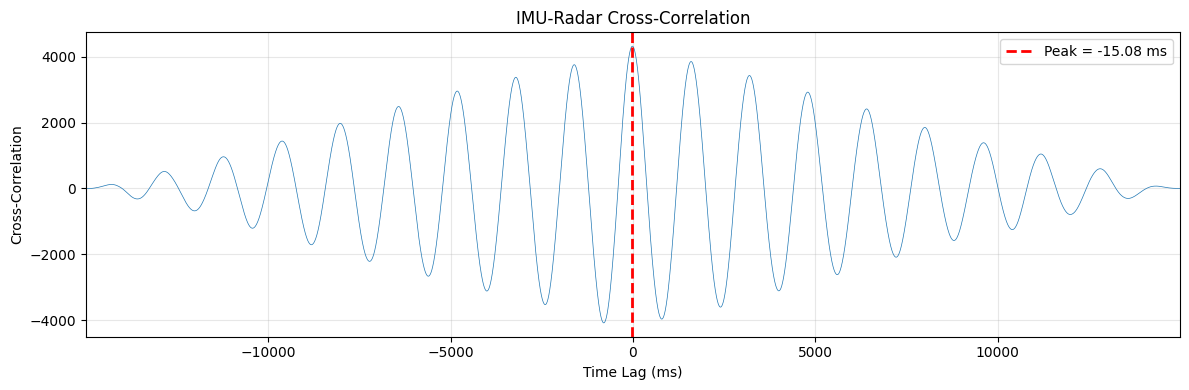

In [8]:
from scipy.signal import find_peaks

# Interpolate radar onto IMU time grid
radar_vx_interp = np.interp(imu_times, radar_times, radar_vx_filt)

# Cross-correlate IMU velocity with Radar velocity
correlation = correlate(imu_vx_filt, radar_vx_interp, mode='full')
lags = np.arange(-len(imu_vx_filt) + 1, len(imu_vx_filt))
lag_times = lags / fs_imu

# Find peak
max_corr_idx = np.argmax(correlation)
time_lag = lag_times[max_corr_idx]

print(f"\n=== TIME ALIGNMENT ===")
print(f"Calculated lag: {time_lag*1000:.2f} ms")
print(f"Interpretation: IMU peaks occur {time_lag*1000:.2f} ms {'BEFORE' if time_lag > 0 else 'AFTER'} Radar peaks")

# Find local maxima and minima in correlation

# Find peaks (maxima)
peaks, _ = find_peaks(correlation)
# Find valleys (minima) by negating
valleys, _ = find_peaks(-correlation)

# Combine extrema indices
extrema_indices = np.concatenate([peaks, valleys])
extrema_lags = lag_times[extrema_indices]
extrema_corr = correlation[extrema_indices]

# Sort by absolute lag from the main peak
abs_lags_from_peak = np.abs(extrema_lags - time_lag)
sorted_indices = np.argsort(abs_lags_from_peak)
top_10_indices = sorted_indices[:10]

print(f"\nTop 10 closest extrema (min & max) to the main peak:")
for i in top_10_indices:
    idx = extrema_indices[i]
    lag_ms = extrema_lags[i] * 1000
    corr_val = extrema_corr[i]
    extrema_type = "max" if idx in peaks else "min"
    print(f"  {extrema_type}: lag={lag_ms:.2f} ms, corr={corr_val:.4f}")

# Plot correlation
plt.figure(figsize=(12, 4))
plt.plot(lag_times * 1000, correlation, linewidth=0.5)
plt.axvline(time_lag * 1000, color='r', linestyle='--', linewidth=2, label=f'Peak = {time_lag*1000:.2f} ms')
plt.xlabel('Time Lag (ms)')
plt.ylabel('Cross-Correlation')
plt.title('IMU-Radar Cross-Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([lag_times[0]*1000, lag_times[-1]*1000])
plt.tight_layout()
plt.show()

## The Wiggle Test: Time Alignment Visualization

Normalize all signals to see if peaks align after time correction.

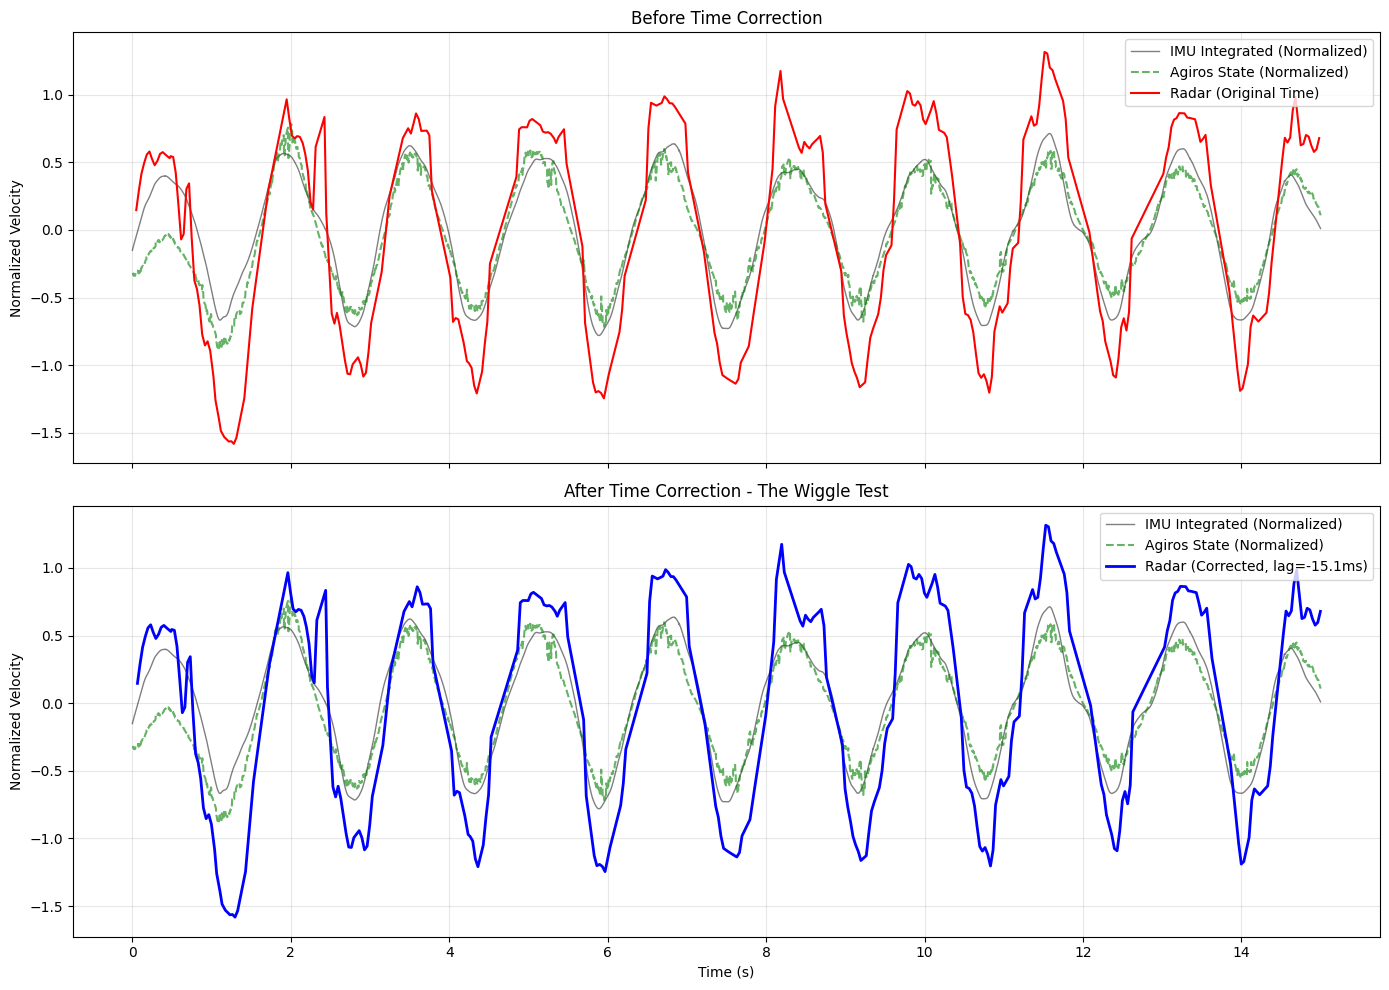

In [9]:
# Apply time correction
radar_times_corrected = radar_times - time_lag

# Normalize signals for comparison
def normalize(x):
    return x / np.max(np.abs(x))

# Relative time (start from zero)
t0 = imu_times[0]

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Before correction
axes[0].plot(imu_times - t0, imu_vx_filt, 'k-', alpha=0.5, linewidth=1, label='IMU Integrated (Normalized)')
axes[0].plot(state_times - t0, state_vx, 'g--', alpha=0.6, linewidth=1.5, label='Agiros State (Normalized)')
axes[0].plot(radar_times - t0, radar_vx_filt, 'r-', linewidth=1.5, label='Radar (Original Time)')
axes[0].set_ylabel('Normalized Velocity')
axes[0].set_title('Before Time Correction')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# After correction
axes[1].plot(imu_times - t0, imu_vx_filt, 'k-', alpha=0.5, linewidth=1, label='IMU Integrated (Normalized)')
axes[1].plot(state_times - t0, state_vx, 'g--', alpha=0.6, linewidth=1.5, label='Agiros State (Normalized)')
axes[1].plot(radar_times_corrected - t0, radar_vx_filt, 'b-', linewidth=2, label=f'Radar (Corrected, lag={time_lag*1000:.1f}ms)')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Normalized Velocity')
axes[1].set_title('After Time Correction - The Wiggle Test')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## CPU Cycle Calibration

In [10]:
# Compute differences to detect decreases (resets)
diffs = np.diff(radar_cpu_cycles)

# Find indices where the counter resets (diff < 0)
reset_indices = np.where(diffs < 0)[0]

# Number of resets
num_resets = len(reset_indices)

print(f"Number of CPU counter resets: {num_resets}")
if num_resets > 0:
    print(f"Reset indices: {reset_indices}")
    print(f"Reset values: {radar_cpu_cycles[reset_indices + 1]}")  # Values after reset
else:
    print("No resets detected.")

Number of CPU counter resets: 0
No resets detected.



=== CPU CYCLE CALIBRATION ===
t_corrected = 1.1193338333e-09 * cpu_cycles + 1765983779.2684
R² = 0.075158
Estimated clock: 893.39 MHz


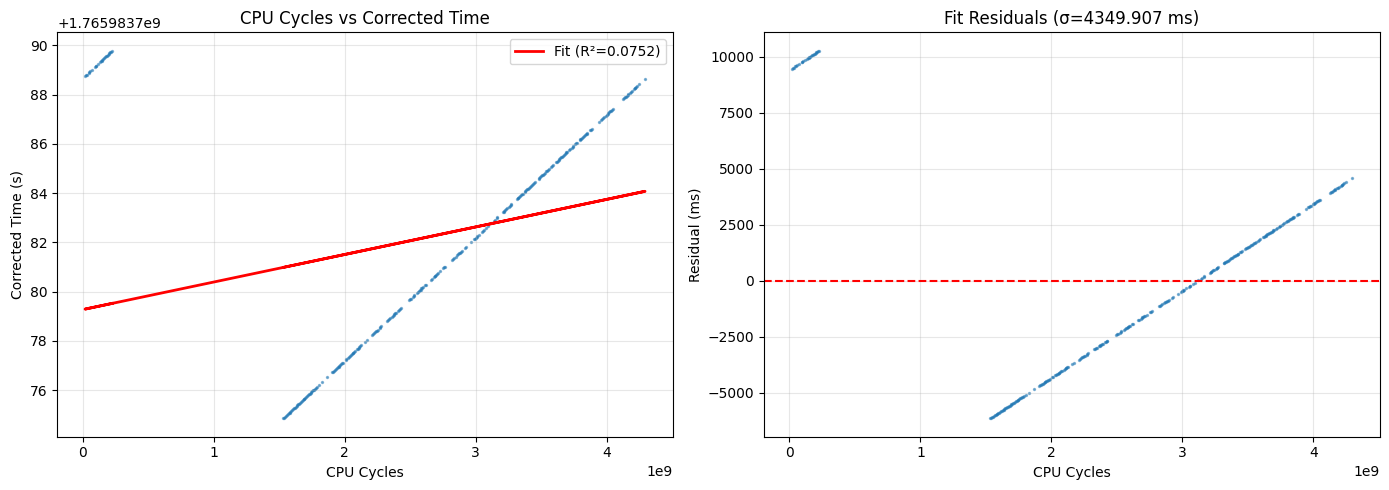

In [11]:
# Filter valid CPU cycles
radar_cpu_cycles = np.array(radar_cpu_cycles)
valid_mask = radar_cpu_cycles > 0
cpu_valid = radar_cpu_cycles[valid_mask]
times_corrected_valid = radar_times_corrected[valid_mask]

if len(cpu_valid) > 10:
    # Linear fit: time = slope * cpu_cycles + intercept
    slope_cpu, intercept_cpu, r_cpu, p_cpu, std_cpu = stats.linregress(cpu_valid, times_corrected_valid)
    
    clock_freq_mhz = 1.0 / slope_cpu / 1e6
    
    print(f"\n=== CPU CYCLE CALIBRATION ===")
    print(f"t_corrected = {slope_cpu:.10e} * cpu_cycles + {intercept_cpu:.4f}")
    print(f"R² = {r_cpu**2:.6f}")
    print(f"Estimated clock: {clock_freq_mhz:.2f} MHz")
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].scatter(cpu_valid, times_corrected_valid, s=2, alpha=0.5)
    axes[0].plot(cpu_valid, slope_cpu*cpu_valid + intercept_cpu, 'r-', linewidth=2, label=f'Fit (R²={r_cpu**2:.4f})')
    axes[0].set_xlabel('CPU Cycles')
    axes[0].set_ylabel('Corrected Time (s)')
    axes[0].set_title('CPU Cycles vs Corrected Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    residuals = times_corrected_valid - (slope_cpu*cpu_valid + intercept_cpu)
    axes[1].scatter(cpu_valid, residuals * 1000, s=2, alpha=0.5)
    axes[1].axhline(0, color='r', linestyle='--')
    axes[1].set_xlabel('CPU Cycles')
    axes[1].set_ylabel('Residual (ms)')
    axes[1].set_title(f'Fit Residuals (σ={np.std(residuals)*1000:.3f} ms)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"\n⚠️ Insufficient CPU cycle data ({len(cpu_valid)} samples)")

## Summary Statistics

In [12]:
# Correlation after alignment
radar_aligned_interp = np.interp(imu_times, radar_times_corrected, radar_vx_filt)
state_interp = np.interp(imu_times, state_times, state_vx)

corr_imu_radar = np.corrcoef(imu_vx_filt, radar_aligned_interp)[0, 1]
corr_state_radar = np.corrcoef(state_interp, radar_aligned_interp)[0, 1]

# RMS errors
rms_imu = np.sqrt(np.mean((imu_vx_filt - radar_aligned_interp)**2))
rms_state = np.sqrt(np.mean((state_interp - radar_aligned_interp)**2))

print(f"\n{'='*50}")
print(f"SUMMARY")
print(f"{'='*50}")
print(f"\nTime Alignment:")
print(f"  Lag: {time_lag*1000:.2f} ms")
print(f"  Correlation (IMU-Radar): {corr_imu_radar:.4f}")
print(f"  RMS error (IMU-Radar): {rms_imu:.3f} m/s")

print(f"\n{'='*50}")


SUMMARY

Time Alignment:
  Lag: -15.08 ms
  Correlation (IMU-Radar): 0.9414
  RMS error (IMU-Radar): 0.365 m/s



## Conclusions

This notebook demonstrates:

1. ✅ **Time alignment** via IMU integration (finds temporal peaks)
2. ✅ **Magnitude validation** via Agiros state (verifies radar calibration)
3. ✅ **Weighted least squares** with intensity-based weights (better noise rejection)
4. ✅ **CPU cycle calibration** for precise time stamping
5. ✅ **Start time filtering** to exclude initial transient period

### Key Findings:
- Time lag between IMU and radar peaks
- Radar magnitude accuracy (slope should ≈ 1.0)
- Correlation quality between signals

Use the calculated lag and calibration factors for sensor fusion.